# Setup

In [1]:
pip install "tensorflow-text>=2.11"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 52.9 MB/s eta 0:00:00


In [2]:
pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.4 MB/s eta 0:00:00


In [3]:
# Modified from https://www.tensorflow.org/text/tutorials/nmt_with_attention
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [4]:
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

# Prepare Dataset

In [5]:
path_to_file = "./sc-data.txt"

In [6]:
from pathlib import Path
def load_data(path):
  path = Path (path)
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  context = np.array([context for target, context in pairs])
  target = np.array([target for target, context in pairs])

  return target, context

In [7]:
target_raw, context_raw = load_data(path_to_file)
print(context_raw[-1])

ခံ ယူ ချ ပ ယ ကာ သွား တယ် ၊ က စား သ မား ရဲ့ ပါင် ကိုယ် ခံ ယူ ချပ် ကို က နိုင် ငံ့ အ တွက် ပေး ဆတ် တာ တော့ ပေး ဆတ် တာ ပေါ့ ။


In [8]:
print(target_raw[-1])

ခံ ယူ ချက် ကွာ သွား တယ် ၊ က စား သ မား ရဲ့ ပင် ကိုယ် ခံ ယူ ချက် ကို က နိုင် ငံ့ အ တွက် ပေး ဆပ် တာ တော့ ပေး ဆပ် တာ ပေါ့ ။


## Create a tf.data dataset

create a tf.data.Dataset of strings that shuffles and batches them efficiently:

In [9]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

## Text Preprocessing

In [10]:
# standardization
from string import punctuation

def standardize(text):
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [11]:
# vectorization
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=standardize,
    max_tokens=max_vocab_size,
    ragged=True)

In [12]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '။', 'အ', 'က', 'တယ်', 'မ', 'ပါ']

In [13]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=standardize,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '။', 'အ', 'က', 'တယ်', 'မ', 'ပါ']

# Process the dataset

The process_text function below converts the Datasets of strings, into 0-padded tensors of token IDs. It also converts from a (context, target) pair to an ((context, target_in), target_out) pair for training with keras.Model.fit. Keras expects (inputs, labels) pairs, the inputs are the (context, target_in) and the labels are target_out. The difference between target_in and target_out is that they are shifted by one step relative to eachother, so that at each location the label is the next token.

In [14]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out

train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [15]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy())
  print()
  print(ex_tar_in[0, :10].numpy())
  print(ex_tar_out[0, :10].numpy())

[   2  109   26   10    5 2804   50  570   25 1320]

[  2 113  22  10   5  65  47 187  26 738]
[113  22  10   5  65  47 187  26 738 370]


# Encoder

The encoder: bidirectional RNN

Takes a list of token IDs (from context_text_processor).

Looks up an embedding vector for each token (Using a layers.Embedding).

Processes the embeddings into a new sequence (Using a bidirectional layers.GRU).

Returns the processed sequence. This will be passed to the attention head.

In [16]:
UNITS = 256

In [17]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [18]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 37)
Encoder output, shape (batch, s, units): (64, 37, 256)


# The attention layer

The attention layer lets the decoder access the information extracted by the encoder. It computes a vector from the entire context sequence, and adds that to the decoder's output.

In [19]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [20]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 37, 256)
Target sequence, shape (batch, t, units): (64, 34, 256)
Attention result, shape (batch, t, units): (64, 34, 256)
Attention weights, shape (batch, t, s):    (64, 34, 37)


The attention weights will sum to 1 over the context sequence, at each location in the target sequence.

In [21]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([0.99999994, 1.        , 1.        , 0.99999994, 1.        ,
       0.99999994, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.0000001 , 1.        , 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994], dtype=float32)

# The decoder

Decoder : unidirectional RNN

The decoder's job is to generate predictions for the next token at each location in the target sequence.

It looks up embeddings for each token in the target sequence.

It uses an RNN to process the target sequence, and keep track of what it has generated so far.

It uses RNN output as the "query" to the attention layer, when attending to the encoder's output.

At each location in the output it predicts the next token.

In [22]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [23]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [24]:
decoder = Decoder(target_text_processor, UNITS)

In [25]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 37, 256)
input target tokens shape: (batch, t) (64, 34)
logits shape shape: (batch, target_vocabulary_size) (64, 34, 2385)


# Inference

In [26]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [27]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [28]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True)

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [29]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)

# The model

In [30]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy.
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [31]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 37)
Target tokens, shape: (batch, t) (64, 34)
logits, shape: (batch, t, target_vocabulary_size) (64, 34, 2385)


# Train

In [32]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [33]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [34]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

The model is randomly initialized, and should give roughly uniform output probabilities. So it's easy to predict what the initial values of the metrics should be:

In [35]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 7.7769547, 'expected_acc': 0.0004192872117400419}

That should roughly match the values returned by running a few steps of evaluation:

In [66]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 8s 19ms/step - loss: 7.6088 - masked_acc: 4.5639e-04 - masked_loss: 7.6088


{'loss': 7.608789920806885,
 'masked_acc': 0.0004563878756016493,
 'masked_loss': 7.608789920806885}

In [36]:
history = model.fit(
    train_ds.repeat(),
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
100/100 [==============================] - 46s 290ms/step - loss: 4.8892 - masked_acc: 0.1923 - masked_loss: 4.8892 - val_loss: 3.8746 - val_masked_acc: 0.3155 - val_masked_loss: 3.8746
Epoch 2/100
100/100 [==============================] - 11s 105ms/step - loss: 3.0988 - masked_acc: 0.4404 - masked_loss: 3.0988 - val_loss: 2.0169 - val_masked_acc: 0.6346 - val_masked_loss: 2.0169
Epoch 3/100
100/100 [==============================] - 9s 89ms/step - loss: 1.5802 - masked_acc: 0.7027 - masked_loss: 1.5802 - val_loss: 1.0804 - val_masked_acc: 0.7990 - val_masked_loss: 1.0804
Epoch 4/100
100/100 [==============================] - 6s 63ms/step - loss: 0.9878 - masked_acc: 0.8082 - masked_loss: 0.9878 - val_loss: 0.8257 - val_masked_acc: 0.8367 - val_masked_loss: 0.8257
Epoch 5/100
100/100 [==============================] - 5s 47ms/step - loss: 0.7854 - masked_acc: 0.8433 - masked_loss: 0.7854 - val_loss: 0.7204 - val_masked_acc: 0.8610 - val_masked_loss: 0.7204
Epoch 6/100
100/

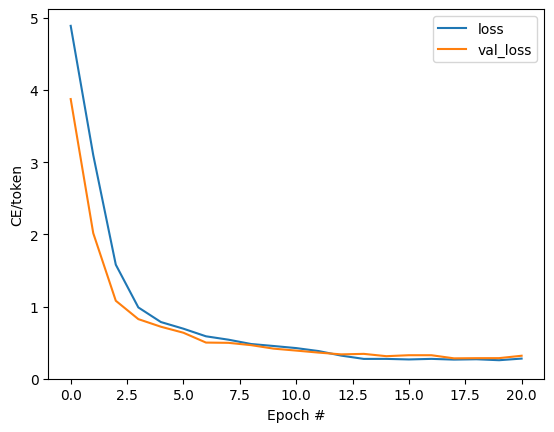

In [37]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

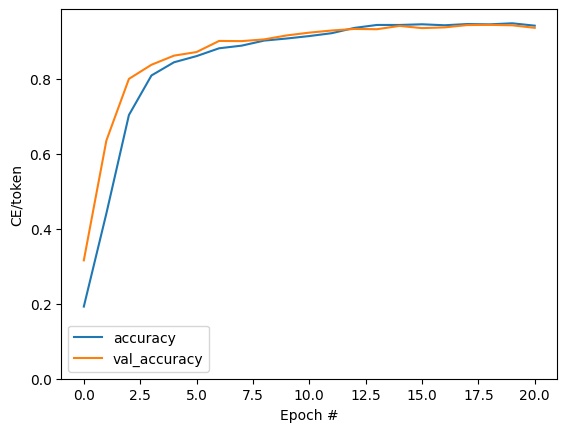

In [38]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

# Translate

In [39]:
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [40]:
result = model.translate(['အ ရေး ကီး တာ မေတ္တာ'])
result[0].numpy().decode()

'အ ရေး ကြီး တာ မေတ္တာ '

In [49]:
inputs = [
    'ငါ တို ရှင် သန် ရာ ပတ် ဝန်း ကျင်',
    'လက် ညှိုး တွေ မျာ တယ်',
    'တစ် လှမ်း ချင်း လျှောက် လဲ ရောက် ရ မယ်'
]

In [50]:
%%time
for t in inputs:
  print(model.translate([t])[0].numpy().decode())

print()

ငါ တို့ ရှင် သန် ရာ ပတ် ဝန်း ကျင် 
လက် ညှိုး တွေ များ တယ် 
တစ် လှမ်း ချင်း လျှောက် လည်း ရောက် ရ မယ် 

CPU times: user 633 ms, sys: 18.6 ms, total: 651 ms
Wall time: 633 ms


# Export

In [51]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [52]:
export = Export(model)

In [53]:
%%time
_ = export.translate(tf.constant(inputs))

CPU times: user 1min 10s, sys: 1.48 s, total: 1min 11s
Wall time: 1min 15s


In [54]:
%%time
result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

ငါ တို့ ရှင် သန် ရာ ပတ် ဝန်း ကျင်                                          
လက် ညှိုး တွေ များ တယ်                                             
တစ် လှမ်း ချင်း လျှောက် လည်း ရောက် ရ မယ်                                          

CPU times: user 140 ms, sys: 6.94 ms, total: 147 ms
Wall time: 143 ms


In [55]:
%%time
tf.saved_model.save(export, 'translator',
                    signatures={'serving_default': export.translate})

CPU times: user 1min 37s, sys: 2.32 s, total: 1min 39s
Wall time: 1min 45s


In [56]:
%%time
reloaded = tf.saved_model.load('translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

CPU times: user 1min 1s, sys: 1.13 s, total: 1min 2s
Wall time: 1min 5s


In [57]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

ငါ တို့ ရှင် သန် ရာ ပတ် ဝန်း ကျင်                                          
လက် ညှိုး တွေ များ တယ်                                             
တစ် လှမ်း ချင်း လျှောက် လည်း ရောက် ရ မယ်                                          

CPU times: user 149 ms, sys: 3.05 ms, total: 152 ms
Wall time: 160 ms
